In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse
import nltk
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
from flashtext import KeywordProcessor
import warnings
warnings.filterwarnings('ignore')

import demoji
 
demoji.download_codes()

In [154]:
# On crée une nouvelle expérimentation
# experiment_id = mlflow.create_experiment("NLP_projet")

# Importation du fichier kaggle

In [1]:
df_train_kaggle = pd.read_csv('../data/kaggle.csv')
df_train_kaggle.info()

df_train_kaggle.Emotion.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

# Importation du fichier data World

In [13]:
df_train_data_world = pd.read_csv('../data/data_world.csv')
df_train_data_world.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [14]:
df_train_data_world = df_train_data_world.drop(columns=['tweet_id', 'author'])
df_train_data_world.rename(columns={'sentiment': 'Emotion'}, inplace=True)
df_train_data_world.rename(columns={'content': 'Text'}, inplace=True)

df_train_full = pd.concat([df_train_data_world, df_train_kaggle])
df_train_full

df_train, df_test,= train_test_split(df_train_full, test_size=0.20 ,random_state=42)
df_test

,Emotion,Text
3114,sadness,i guess since im feeling a bit less shitty have a random picture
26628,worry,Bank holiday = rain. Superb. But a great excuse not to start gardening in the jungle at the back of our house. Eating it is then...
4118,anger,i don t feel whack or messed up i know i m psychologically fucked up because i can feel the difference but i don t feel like i m as fucked up as i could be
14300,worry,"Sad that Gmail chat has died, so I can't help @natalidelconte"
4596,anger,i don t feel bitter about my lot nor do i wish any other mother s son was in my place
...,...,...
29972,worry,Hehe nah just doing this and watching Ace of Cakes with @jlsegarra while our 4-legged &quot;kids&quot; run around. Couldn't ask for more
21203,happiness,Happy Birthday tooo meeee... Happy Birthday tooo meeee...
24112,surprise,"@Sazchik I read somewhere they were restoring the name, hope it happens soon"
9774,happy,i feel a little like a traitor to my beloved oppies but that said these clothes might just pay off a big chunk of my remaining debt and we all know that money is more important than ethics right


In [ ]:
df_test

filepath = Path('data/df_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_test.to_csv(filepath, index=False)

## 1°) Cleaning dataWorld

In [158]:
# Suppprime les url
df_train_data_world.Text = df_train_data_world.Text.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'(www\.[^\s]+)|(https?://[^\s]+)', '', regex=True)
# Supprime les unicodes
# df_train_data_world.Text = df_train_data_world.Text.replace(r'\\u [0-9A-Za-z]+', '', regex=True).replace(r'[^\x00-\x7f]', '', regex=True)
# Supprime les surnoms
df_train_data_world.Text = df_train_data_world.Text.replace(r'@[^\s]+', '', regex=True).replace(r'#[^\s]+', '', regex=True)
# Remplace les emojis


all_emoji_emoticons = {**EMOTICONS_EMO,**UNICODE_EMOJI_ALIAS, **UNICODE_EMOJI_ALIAS}
all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}

kp_all_emoji_emoticons = KeywordProcessor()
for k,v in all_emoji_emoticons.items():
    kp_all_emoji_emoticons.add_keyword(k, v)
for sentence in df_train_data_world.Text:
    kp_all_emoji_emoticons.replace_keywords(sentence)
df_train_data_world.Text 


0         i know  i was listenin to bad habit earlier a...
1        Layin n bed with a headache  ughhhh...waitin o...
2                      Funeral ceremony...gloomy friday...
3                     wants to hang out with friends SOON!
4         We want to trade with someone who has Houston...
                               ...                        
39995                                                     
39996                       Happy Mothers Day  All my love
39997    Happy Mother's Day to all the mommies out ther...
39998     WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEEP OUT MY ...
39999     bullet train from tokyo    the gf and i have ...
Name: Text, Length: 40000, dtype: object

In [159]:
#3.removing abbrevations
d = {' AFAIK ':' As Far As I Know ',' AFK ':' Away From Keyboard ',' ASAP ':' As Soon As Possible ',' ATK ':' At The Keyboard ',' ATM ':' At The Moment ',' A3 ':' Anytime, Anywhere, Anyplace ',' BAK ':' Back At Keyboard ',' BBL ':' Be Back Later ',' BBS ':' Be Back Soon ',' BFN ':' Bye For Now ',' B4N ':' Bye For Now ',' BRB ':' Be Right Back ',' BRT ':' Be Right There ',' BTW ':' By The Way ',' B4 ':' Before ','B4N':'Bye For Now','CU':'See You','CUL8R':'See You Later','CYA':'See You','FAQ':'Frequently Asked Questions','FC':'Fingers Crossed','FWIW':'For What It is Worth','FYI':'For Your Information','GAL':'Get A Life','GG':'Good Game','GN':'Good Night','GMTA':'Great Minds Think Alike','GR8':'Great!','G9':'Genius','IC':'I See','ICQ':'I Seek you','ILU':'I Love You','IMHO':'In My Honest/Humble Opinion','IMO':'In My Opinion','IOW':'In Other Words','IRL':'In Real Life','KISS':'Keep It Simple, Stupid','LDR':'Long Distance Relationship','LMAO':'Laugh My A.. Off','LOL':'Laughing Out Loud','LTNS':'Long Time No See','L8R':'Later','MTE':'My Thoughts Exactly','M8':'Mate','NRN':'No Reply Necessary','OMG':'Oh My God','OIC':'Oh I See','PITA':'Pain In The A..','PRT':'Party','PRW':'Parents Are Watching','QPSA?':'Que Pasa?','ROFL':'Rolling On The Floor Laughing','ROFLOL':'Rolling On The Floor Laughing Out Loud','ROTFLMAO':'Rolling On The Floor Laughing My A.. Off','SK8':'Skate','STATS':'Your sex and age','ASL':'Age, Sex, Location','THX':'Thank You','TTFN':'Ta-Ta For Now!','TTYL':'Talk To You Later',' U ':' You ','U2':'You Too','U4E':'Yours For Ever','WB':'Welcome Back','WTF':'What The F...','WTG':'Way To Go!','WUF':'Where Are You From?','W8':'Wait...','7K':'Sick'}
dic = {}
for k, v in d.items():
    key, value = ' ' + k.lower().strip() + ' ', v.lower()
    dic[key] = value
result = []
for text in df_train_data_world.Text:
    for word in text.split():
        if word in dic:
            text = text.replace(word, dic[word])
    result.append(text)
df_train_data_world.Text = result
df_train_data_world.Text.head(5)

0     i know  i was listenin to bad habit earlier a...
1    Layin n bed with a headache  ughhhh...waitin o...
2                  Funeral ceremony...gloomy friday...
3                 wants to hang out with friends SOON!
4     We want to trade with someone who has Houston...
Name: Text, dtype: object

In [160]:
#4.Replacing contractions
contractions = {"ain't": "am not / are not","aren't": "are not / am not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he had / he would","he'd've": "he would have","he'll": "he shall / he will","he'll've": "he shall have / he will have","he's": "he has / he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how has / how is","i'd": "I had / I would","i'd've": "I would have","i'll": "I shall / I will","i'll've": "I shall have / I will have","i'm": "I am","i've": "I have","isn't": "is not","it'd": "it had / it would","it'd've": "it would have","it'll": "it shall / it will","it'll've": "it shall have / it will have","it's": "it has / it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she had / she would","she'd've": "she would have","she'll": "she shall / she will","she'll've": "she shall have / she will have","she's": "she has / she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so as / so is","that'd": "that would / that had","that'd've": "that would have","that's": "that has / that is","there'd": "there had / there would","there'd've": "there would have","there's": "there has / there is","they'd": "they had / they would","they'd've": "they would have","they'll": "they shall / they will","they'll've": "they shall have / they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had / we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not","what'll": "what shall / what will","what'll've": "what shall have / what will have","what're": "what are","what's": "what has / what is","what've": "what have","when's": "when has / when is","when've": "when have","where'd": "where did","where's": "where has / where is","where've": "where have","who'll": "who shall / who will","who'll've": "who shall have / who will have","who's": "who has / who is","who've": "who have","why's": "why has / why is","why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had / you would","you'd've": "you would have","you'll": "you shall / you will","you'll've": "you shall have / you will have","you're": "you are","you've": "you have"}
result = []
for text in df_train_data_world.Text:
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    result.append(text)
df_train_data_world.Text = result
df_train_data_world.Text.head(5)

0     i know  i was listenin to bad habit earlier a...
1    Layin n bed with a headache  ughhhh...waitin o...
2                  Funeral ceremony...gloomy friday...
3                 wants to hang out with friends SOON!
4     We want to trade with someone who has Houston...
Name: Text, dtype: object

In [161]:
#5.Removing Numbers
result = []
for text in df_train_data_world.Text:
    text = ''.join([i for i in text if not i.isdigit()])
    result.append(text)
df_train_data_world.Text = result
df_train_data_world.Text.head(5)

0     i know  i was listenin to bad habit earlier a...
1    Layin n bed with a headache  ughhhh...waitin o...
2                  Funeral ceremony...gloomy friday...
3                 wants to hang out with friends SOON!
4     We want to trade with someone who has Houston...
Name: Text, dtype: object

In [162]:
#6. Replacing multiple punctuations
# result = []
# for text in df_train_data_world.Text:
#     text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
#     text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
#     text = re.sub(r"(\.)\1+", ' multiStop ', text)
#     result.append(text)
# df_train_data_world.Text = result
# df_train_data_world.Text.head(5)

In [163]:
#7. Replacing negations with antonyms
from nltk.corpus import wordnet, stopwords
def replace(word, pos=None):
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
      for lemma in syn.lemmas():
        for antonym in lemma.antonyms():
          antonyms.add(antonym.name())
    if len(antonyms) == 1:
      return antonyms.pop()
    else:
      return None

def replaceNegations(text):
    i, l = 0, len(text)
    words = []
    while i < l:
      word = text[i]
      if word == 'not' and i+1 < l:
        ant = replace(text[i+1])
        if ant:
          words.append(ant)
          i += 2
          continue
      words.append(word)
      i += 1
    return words

result = []
for text in df_train_data_world.Text:
    text = replaceNegations(text)
    result.append(text)
for i in range(len(df_train_data_world.Text)):
    df_train_data_world.Text[i] = ''.join(df_train_data_world.Text[i])
df_train_data_world.Text = result
for i in range(len(df_train_data_world.Text)):
    df_train_data_world.Text[i] = ''.join(df_train_data_world.Text[i])
df_train_data_world.Text.head(5)


stops_r = list(map(lambda x: x.replace("'",""), stopwords.words('english')))
stops = set(stopwords.words('english') + stops_r)
for word in stops:
    df_train_data_world['Text'] = df_train_data_world['Text'].str.replace(' ' + word + ' ', ' ')
df_train_data_world['Text'] = df_train_data_world['Text'].str.replace('^i ', '', regex=True).replace('^im ', '', regex=True).replace('^I ', '', regex=True).replace('^Im ', '', regex=True)

In [164]:
#tokenization
df_train_data_world.Text = df_train_data_world.Text.apply(lambda x: x.split())
df_train_data_world.Text.head()

0    [know, listenin, bad, habit, earlier, started,...
1    [Layin, n, bed, headache, ughhhh...waitin, cal...
2              [Funeral, ceremony...gloomy, friday...]
3                        [wants, hang, friends, SOON!]
4    [We, want, trade, someone, Houston, tickets,, ...
Name: Text, dtype: object

In [165]:
#12. Stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()
df_train_data_world.Text = df_train_data_world.Text.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(df_train_data_world.Text)):
    df_train_data_world.Text[i] = ' '.join(df_train_data_world.Text[i])
df_train_data_world.Text.head(5)

0    know listenin bad habit earlier start freakin ...
1          layin n bed headach ughhhh...waitin call...
2                    funer ceremony...gloomi friday...
3                               want hang friend soon!
4      we want trade someon houston tickets, one will.
Name: Text, dtype: object

## 2°) Cleaning Data Kaggle

In [166]:
# Suppprime les url
df_train_kaggle.Text = df_train_kaggle.Text.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'(www\.[^\s]+)|(https?://[^\s]+)', '', regex=True).replace('(http://|https://|ftp://|ssh://)\S*','',regex=True)
# Supprime les unicodes
# df_train_kaggle.Text = df_train_kaggle.Text.replace(r'\\u [0-9A-Za-z]+', '', regex=True).replace(r'[^\x00-\x7f]', '', regex=True)
# Supprime les surnoms
df_train_kaggle.Text = df_train_kaggle.Text.replace(r'@[^\s]+', '', regex=True).replace(r'#[^\s]+', '', regex=True).replace('@\S*','',regex=True)
# Remplace les emojis
from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
from flashtext import KeywordProcessor

all_emoji_emoticons = {**EMOTICONS_EMO,**UNICODE_EMOJI_ALIAS, **UNICODE_EMOJI_ALIAS}
all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}

kp_all_emoji_emoticons = KeywordProcessor()
for k,v in all_emoji_emoticons.items():
    kp_all_emoji_emoticons.add_keyword(k, v)
for sentence in df_train_kaggle.Text:
    kp_all_emoji_emoticons.replace_keywords(sentence)
df_train_kaggle.Text 


0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
21454                 Melissa stared at her friend in dism
21455    Successive state elections have seen the gover...
21456                 Vincent was irritated but not dismay
21457    Kendall-Hume turned back to face the dismayed ...
21458                      I am dismayed , but not surpris
Name: Text, Length: 21459, dtype: object

In [167]:
#3.removing abbrevations
d = {' AFAIK ':' As Far As I Know ',' AFK ':' Away From Keyboard ',' ASAP ':' As Soon As Possible ',' ATK ':' At The Keyboard ',' ATM ':' At The Moment ',' A3 ':' Anytime, Anywhere, Anyplace ',' BAK ':' Back At Keyboard ',' BBL ':' Be Back Later ',' BBS ':' Be Back Soon ',' BFN ':' Bye For Now ',' B4N ':' Bye For Now ',' BRB ':' Be Right Back ',' BRT ':' Be Right There ',' BTW ':' By The Way ',' B4 ':' Before ','B4N':'Bye For Now','CU':'See You','CUL8R':'See You Later','CYA':'See You','FAQ':'Frequently Asked Questions','FC':'Fingers Crossed','FWIW':'For What It is Worth','FYI':'For Your Information','GAL':'Get A Life','GG':'Good Game','GN':'Good Night','GMTA':'Great Minds Think Alike','GR8':'Great!','G9':'Genius','IC':'I See','ICQ':'I Seek you','ILU':'I Love You','IMHO':'In My Honest/Humble Opinion','IMO':'In My Opinion','IOW':'In Other Words','IRL':'In Real Life','KISS':'Keep It Simple, Stupid','LDR':'Long Distance Relationship','LMAO':'Laugh My A.. Off','LOL':'Laughing Out Loud','LTNS':'Long Time No See','L8R':'Later','MTE':'My Thoughts Exactly','M8':'Mate','NRN':'No Reply Necessary','OMG':'Oh My God','OIC':'Oh I See','PITA':'Pain In The A..','PRT':'Party','PRW':'Parents Are Watching','QPSA?':'Que Pasa?','ROFL':'Rolling On The Floor Laughing','ROFLOL':'Rolling On The Floor Laughing Out Loud','ROTFLMAO':'Rolling On The Floor Laughing My A.. Off','SK8':'Skate','STATS':'Your sex and age','ASL':'Age, Sex, Location','THX':'Thank You','TTFN':'Ta-Ta For Now!','TTYL':'Talk To You Later',' U ':' You ','U2':'You Too','U4E':'Yours For Ever','WB':'Welcome Back','WTF':'What The F...','WTG':'Way To Go!','WUF':'Where Are You From?','W8':'Wait...','7K':'Sick'}
result = []
for text in df_train_kaggle.Text:
    for word in text.split():
        if word in d:
            text = text.replace(word, d[word])
    result.append(text)
df_train_kaggle.Text = result
df_train_kaggle.Text.head(5)

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: Text, dtype: object

In [168]:
#4.Replacing contractions
contractions = {"ain't": "am not / are not","aren't": "are not / am not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he had / he would","he'd've": "he would have","he'll": "he shall / he will","he'll've": "he shall have / he will have","he's": "he has / he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how has / how is","i'd": "I had / I would","i'd've": "I would have","i'll": "I shall / I will","i'll've": "I shall have / I will have","i'm": "I am","i've": "I have","isn't": "is not","it'd": "it had / it would","it'd've": "it would have","it'll": "it shall / it will","it'll've": "it shall have / it will have","it's": "it has / it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she had / she would","she'd've": "she would have","she'll": "she shall / she will","she'll've": "she shall have / she will have","she's": "she has / she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so as / so is","that'd": "that would / that had","that'd've": "that would have","that's": "that has / that is","there'd": "there had / there would","there'd've": "there would have","there's": "there has / there is","they'd": "they had / they would","they'd've": "they would have","they'll": "they shall / they will","they'll've": "they shall have / they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had / we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not","what'll": "what shall / what will","what'll've": "what shall have / what will have","what're": "what are","what's": "what has / what is","what've": "what have","when's": "when has / when is","when've": "when have","where'd": "where did","where's": "where has / where is","where've": "where have","who'll": "who shall / who will","who'll've": "who shall have / who will have","who's": "who has / who is","who've": "who have","why's": "why has / why is","why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had / you would","you'd've": "you would have","you'll": "you shall / you will","you'll've": "you shall have / you will have","you're": "you are","you've": "you have"}
result = []
for text in df_train_kaggle.Text:
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    result.append(text)
df_train_kaggle.Text = result
df_train_kaggle.Text.head(5)

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: Text, dtype: object

In [169]:
#5.Removing Numbers
result = []
for text in df_train_kaggle.Text:
    text = ''.join([i for i in text if not i.isdigit()])
    result.append(text)
df_train_kaggle.Text = result
df_train_kaggle.Text.head(5)

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: Text, dtype: object

In [170]:
#6. Replacing multiple punctuations
result = []
for text in df_train_kaggle.Text:
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    result.append(text)
df_train_kaggle.Text = result
df_train_kaggle.Text.head(5)

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: Text, dtype: object

In [171]:
#7. Replacing negations with antonyms
from nltk.corpus import wordnet
def replace(word, pos=None):
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
      for lemma in syn.lemmas():
        for antonym in lemma.antonyms():
          antonyms.add(antonym.name())
    if len(antonyms) == 1:
      return antonyms.pop()
    else:
      return None

def replaceNegations(text):
    i, l = 0, len(text)
    words = []
    while i < l:
      word = text[i]
      if word == 'not' and i+1 < l:
        ant = replace(text[i+1])
        if ant:
          words.append(ant)
          i += 2
          continue
      words.append(word)
      i += 1
    return words

result = []
for text in df_train_kaggle.Text:
    text = replaceNegations(text)
    result.append(text)
for i in range(len(df_train_kaggle.Text)):
    df_train_kaggle.Text[i] = ''.join(df_train_kaggle.Text[i])
df_train_kaggle.Text = result
for i in range(len(df_train_kaggle.Text)):
    df_train_kaggle.Text[i] = ''.join(df_train_kaggle.Text[i])
df_train_kaggle.Text.head(5)

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: Text, dtype: object

In [172]:
#tokenization
df_train_kaggle.Text = df_train_kaggle.Text.apply(lambda x: x.split())
df_train_kaggle.Text.head()

0                         [i, didnt, feel, humiliated]
1    [i, can, go, from, feeling, so, hopeless, to, ...
2    [im, grabbing, a, minute, to, post, i, feel, g...
3    [i, am, ever, feeling, nostalgic, about, the, ...
4                            [i, am, feeling, grouchy]
Name: Text, dtype: object

In [173]:
#12. Stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()
df_train_kaggle.Text = df_train_kaggle.Text.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(df_train_kaggle.Text)):
    df_train_kaggle.Text[i] = ' '.join(df_train_kaggle.Text[i])
df_train_kaggle.Text.head(5)

0                                  i didnt feel humili
1    i can go from feel so hopeless to so damn hope...
2          im grab a minut to post i feel greedi wrong
3    i am ever feel nostalg about the fireplac i wi...
4                                    i am feel grouchi
Name: Text, dtype: object

Text(-24.680555555555557, 0.5, 'Count')

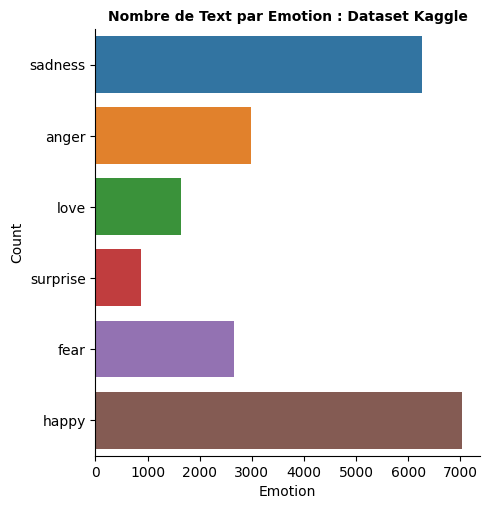

In [174]:
fontdict = {'fontsize': 10, 'fontweight': 'bold'}

sns.catplot(y='Emotion', kind='count', data=df_train_kaggle)
plt.title('Nombre de Text par Emotion : Dataset Kaggle', fontdict= fontdict)
plt.xlabel("Emotion") 
plt.ylabel("Count") 

Text(-49.05555555555556, 0.5, 'Count')

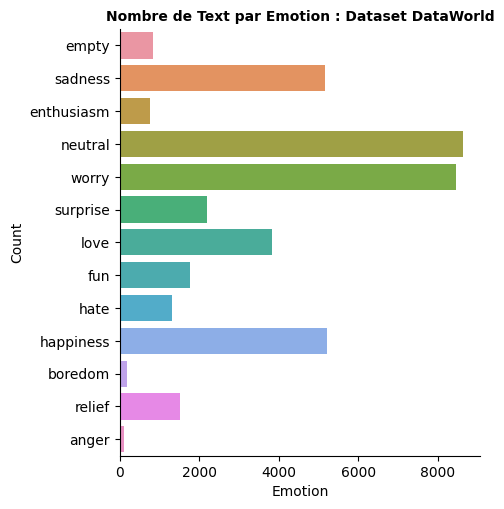

In [175]:
sns.catplot(y='Emotion', kind='count', data=df_train_data_world) 
plt.title('Nombre de Text par Emotion : Dataset DataWorld', fontdict= fontdict)
plt.xlabel("Emotion") 
plt.ylabel("Count") 

In [176]:
# happy : happiness, fun, relief, enthusiasm
# sadness : sadness, boredom
# anger : anger, hate, 
# fear : worry 
# love : love
# surprise : surprise 

# empty : on supprime
# neutral : on supprime

In [177]:
# liste_happy = ['happiness','fun','relief','enthusiasm']
liste_happy = ['happiness']
liste_sadness = ['sadness','boredom']
liste_anger = ['anger','hate']
liste_fear = ['worry']
liste_love = ['love']
liste_surprise = ['surprise']

In [178]:
df_train_data_world['Emotion'] = df_train_data_world['Emotion'].replace(liste_happy,'happy')
df_train_data_world['Emotion'] = df_train_data_world['Emotion'].replace(liste_sadness,'sadness')
df_train_data_world['Emotion'] = df_train_data_world['Emotion'].replace(liste_anger,'anger')
df_train_data_world['Emotion'] = df_train_data_world['Emotion'].replace(liste_fear,'fear')
df_train_data_world['Emotion'] = df_train_data_world['Emotion'].replace(liste_love,'love')
df_train_data_world['Emotion'] = df_train_data_world['Emotion'].replace(liste_surprise,'surprise')
df_train_data_world['Emotion']

df_train_data_world.drop(df_train_data_world.loc[df_train_data_world['Emotion']=='empty'].index, inplace=True)
df_train_data_world.drop(df_train_data_world.loc[df_train_data_world['Emotion']=='neutral'].index, inplace=True)

df_train_data_world.drop(df_train_data_world.loc[df_train_data_world['Emotion']=='fun'].index, inplace=True)
df_train_data_world.drop(df_train_data_world.loc[df_train_data_world['Emotion']=='relief'].index, inplace=True)
df_train_data_world.drop(df_train_data_world.loc[df_train_data_world['Emotion']=='enthusiasm'].index, inplace=True)

In [179]:
df_train_full = pd.concat([df_train_data_world, df_train_kaggle])
df_train_full

,Emotion,Text
1,sadness,layin n bed headach ughhhh...waitin call...
2,sadness,funer ceremony...gloomi friday...
5,fear,re-ping go prom? bc bf like friend
6,sadness,"sleep, im not! think old friend i want. / marri now. damn, &amp; want ! scandalous!"
7,fear,hmmm. down
...,...,...
21454,fear,melissa stare at her friend in dism
21455,fear,success state elect have seen the govern parti pummel by a dismay electora
21456,fear,vincent wa irrit but not dismay
21457,fear,kendall-hum turn back to face the dismay coup


Text(-24.680555555555557, 0.5, 'Count')

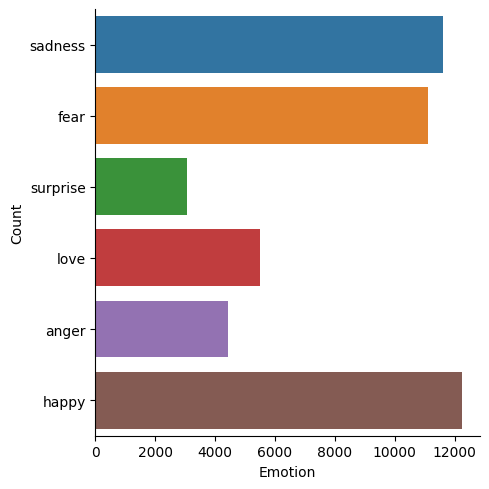

In [180]:
sns.catplot(y='Emotion', kind='count', data=df_train_full) 
plt.xlabel("Emotion") 
plt.ylabel("Count")

In [181]:
categories = df_train_full.Emotion.unique()
categories

array(['sadness', 'fear', 'surprise', 'love', 'anger', 'happy'],
      dtype=object)

In [182]:
df_train_data_world.Text.isna().sum()

0

In [183]:
df_train_data_world.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26474 entries, 1 to 39999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  26474 non-null  object
 1   Text     26474 non-null  object
dtypes: object(2)
memory usage: 620.5+ KB


In [184]:
filepath = Path('data/df_train_kaggle.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_train_kaggle.to_csv(filepath, index=False)


In [185]:
filepath = Path('data/df_train_data_world.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_train_data_world.to_csv(filepath, index=False)


In [186]:
filepath = Path('data/df_train_full.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_train_full.to_csv(filepath, index=False)
